In [7]:
import openpyxl
from collections import defaultdict, Counter
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.datasets import fetch_20newsgroups

In [2]:
def plot_top_words(axes, model, feature_names, n_top_words, title):
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f'{title}\nTopic {topic_idx +1}',
                     fontdict={'fontsize': 30})
        ax.invert_yaxis()
        ax.tick_params(axis='both', which='major', labelsize=20)
        for i in 'top right left'.split():
            ax.spines[i].set_visible(False)

# Model

In [3]:
categories = ['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']
categories = ['alt.atheism',
 'comp.graphics',
 'comp.sys.ibm.pc.hardware',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'talk.politics.guns',
 'talk.politics.mideast',]
queries = [c.split('.')[-1] for c in categories]

In [4]:
n_features = 1000
n_components = 5
n_top_words = 20

In [17]:
data, _ = fetch_20newsgroups(categories=categories, return_X_y=True, remove=('headers', 'footers', 'quotes'))
tfidf_vectorizer = TfidfVectorizer(max_df=0.5, min_df=2,
                                   max_features=None,
                                   stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(data)

atheism 54
graphics 172
hardware 169
autos 29
motorcycles 35
baseball 123
hockey 146
crypt 36
electronics 67
med 34
space 306
guns 140
mideast 13


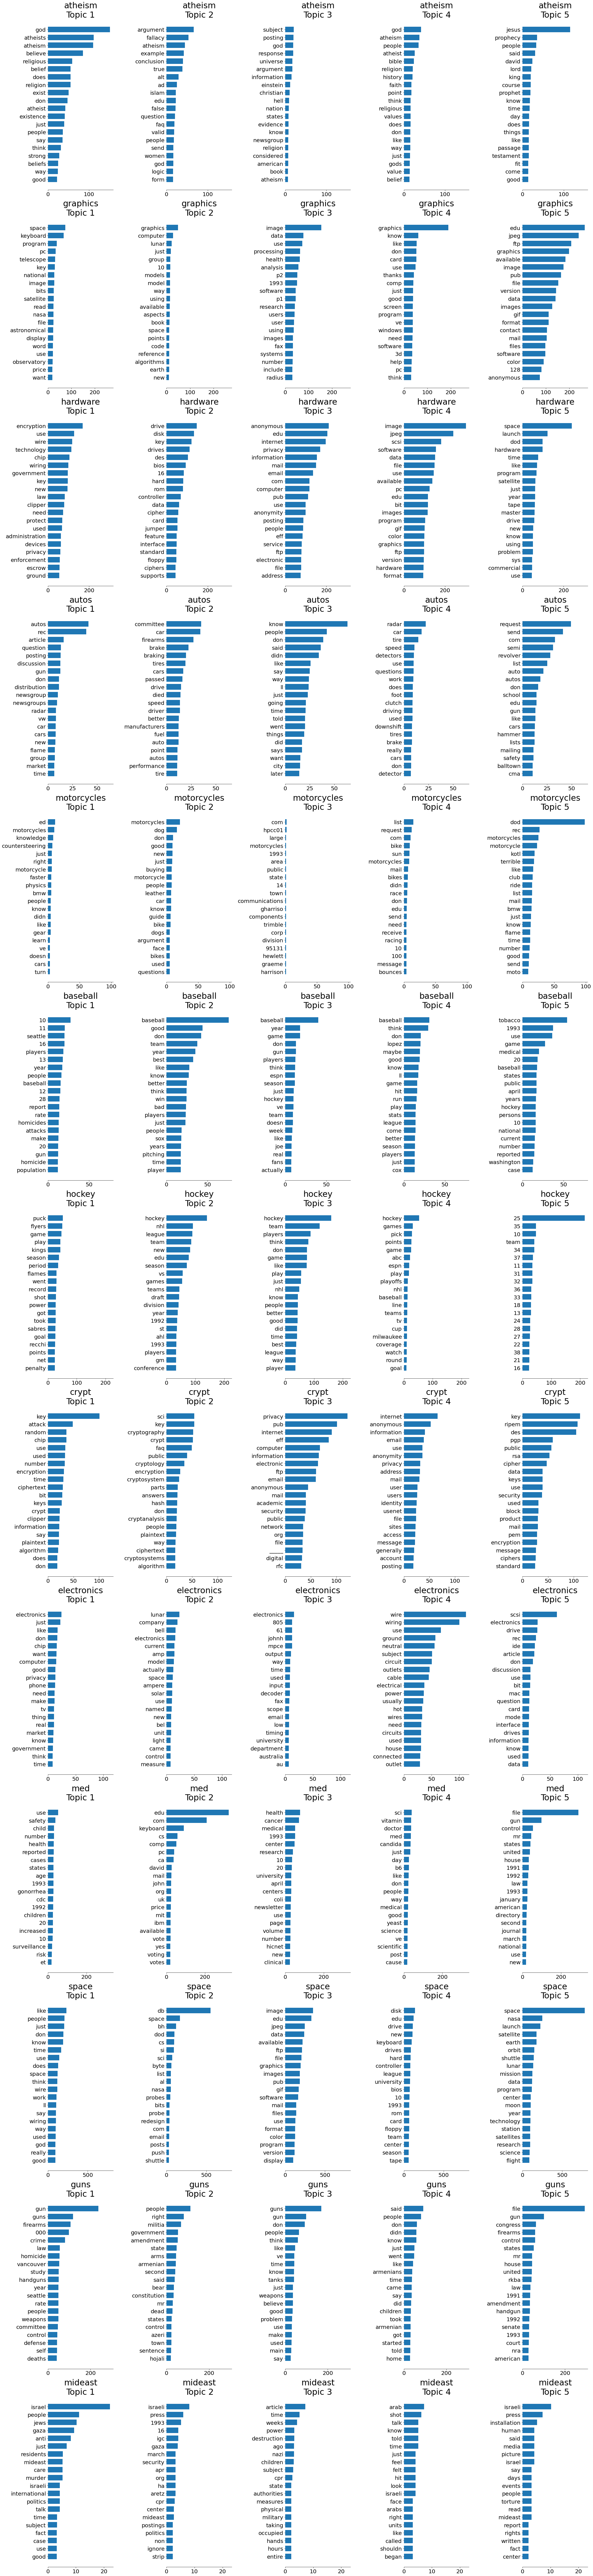

In [44]:
fig, axes = plt.subplots(len(categories), 5, figsize=(30, len(categories)*10), sharex='row')
axes = axes.flatten()
models = []

for i, q in enumerate(queries):
    # docs that hit the keyword q
    idx = tfidf_vectorizer.vocabulary_[q]
    docs = [data[j] for j in range(len(data)) if tfidf[j,idx]>0]
    print(q, len(docs))
    
    tf_vectorizer = CountVectorizer(max_df=1.0, min_df=2,
                                max_features=n_features,
                                stop_words='english')
    tf = tf_vectorizer.fit_transform(docs)
    tf_feature_names = tf_vectorizer.get_feature_names()
    
    lda = LatentDirichletAllocation(n_components=n_components, max_iter=10, random_state=0)
    lda.fit(tf)
    
    axes_ = axes[i*n_components: (i+1)*n_components + 1]
    plot_top_words(axes_, lda, tf_feature_names, n_top_words, f'{q}')
    
    doc_word_list = [np.nonzero(tf[i])[1] for i in range(len(docs))]
    doc_lens = [len(doc) for doc in docs]
    models.append((q, lda.components_, doc_word_list, doc_lens, tf_feature_names))
    
fig.tight_layout()

In [46]:
import pickle

samp = []
for q, components, doc_word_list, doc_lens, words in models:
    samp.append((q, components, doc_word_list, doc_lens, words))

with open('datasets/news.pkl', 'wb') as fout:
    pickle.dump(samp, fout)